<h1> <b> Monkey Species Classification:</b> Neural Network </h1>

In [31]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import linear, relu
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
np.set_printoptions(precision=2)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)



<h2> Preparing Data for training: </h2>

In [32]:
train_dir = "./archive/training/training"
val_dir = "./archive/validation/validation"
# Image agmentation and normalization by rescaling
train_data_generator = ImageDataGenerator(
    rescale = 1./255, #Normalize
    horizontal_flip = True,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 2.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = "nearest" #fill newly created pizels
)
val_data_generator = ImageDataGenerator(rescale = 1./255) # no agmentation for val data set

#Flow training images using train_datagen

train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "sparse"
)

validation_generator = val_data_generator.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "sparse"
)
x_batch, y_batch = next(train_generator)
print(f"Shape of the features: {x_batch.shape}")
print(f"Shape of the target values: {y_batch.shape}")
print(os.listdir(train_dir))

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
Shape of the features: (32, 224, 224, 3)
Shape of the target values: (32,)
['bald_uakari', 'common_squirrel_monkey', '.DS_Store', 'japanese_macaque', 'pygmy_marmoset', 'patas_monkey', 'silvery_marmoset', 'nilgiri_langur', 'black_headed_night_monkey', 'mantled_howler', 'white_headed_capuchin']


{'bald_uakari': 0, 'black_headed_night_monkey': 1, 'common_squirrel_monkey': 2, 'japanese_macaque': 3, 'mantled_howler': 4, 'nilgiri_langur': 5, 'patas_monkey': 6, 'pygmy_marmoset': 7, 'silvery_marmoset': 8, 'white_headed_capuchin': 9}


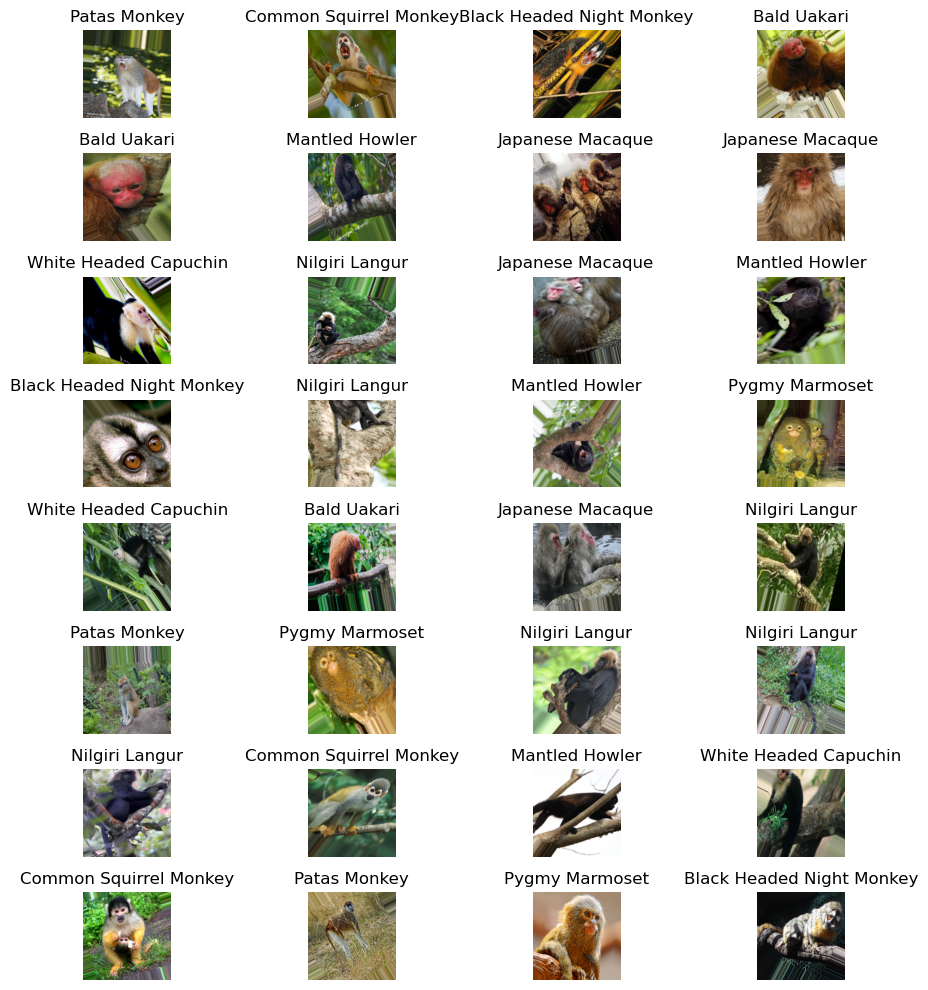

In [33]:
species_dictionary = {
    0 : "Bald Uakari",
    1 : "Black Headed Night Monkey",
    2 : "Common Squirrel Monkey",
    3 : "Japanese Macaque",
    4 : "Mantled Howler",
    5 : "Nilgiri Langur",
    6 : "Patas Monkey",
    7 : "Pygmy Marmoset",
    8 : "Silvery Marmoset",
    9 : "White Headed Capuchin"
    }
print(train_generator.class_indices)
# Fetch a batch of images and labels from the generator
x_batch, y_batch = next(train_generator)

batch_size = x_batch.shape[0]

fig, ax = plt.subplots(int(batch_size / 4), 4, figsize=(10, 10))
# If we have more axes than images, flatten the array and turn off the excess axes
ax = ax.flatten()

for i in range(batch_size):
    img = x_batch[i]
    target = y_batch[i]

    ax[i].imshow(img)

    # Set the title of the subplot to the class index
    ax[i].set_title(species_dictionary.get(target, 0))
    ax[i].axis('off')

plt.tight_layout()
plt.show()


<h2> Multi Classification Neural Network TensorFlow Implementation: </h2>

In [59]:
tf.random.set_seed(1234)
# Comment and uncomment code to experiment with layers
model = Sequential(
    [
        Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 3)), #param 1 = num of filters param 2 = size of filters
        MaxPooling2D((2,2)), # makes small window that slides across feature map
        Conv2D(64, (3, 3), activation = "relu"), #was 64
        MaxPooling2D((2,2)),
        Conv2D(128, (3, 3), activation = "relu"),
        MaxPooling2D((2,2)),
        Flatten(), #turns multi-demensional input into one-dimentional array
        Dense(224, activation = "relu", kernel_regularizer = L2(0.00001)),
        Dropout(0.5), #temporarily dropout neurons during each training pass to prevent overfitting  
        Dense(units = 10, activation = "linear")
    ], name = "monkey_classification"
)

In [60]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")
    if hasattr(layer, "get_weights"):
        weights = layer.get_weights()
        if weights:
            W, b = weights
            print(f"W{i} shape = {W.shape}, b{i} shape = {b.shape}")
model.summary()

Layer 0: conv2d_39
W0 shape = (3, 3, 3, 32), b0 shape = (32,)
Layer 1: max_pooling2d_39
Layer 2: conv2d_40
W2 shape = (3, 3, 32, 64), b2 shape = (64,)
Layer 3: max_pooling2d_40
Layer 4: conv2d_41
W4 shape = (3, 3, 64, 128), b4 shape = (128,)
Layer 5: max_pooling2d_41
Layer 6: flatten_13
Layer 7: dense_39
W7 shape = (86528, 224), b7 shape = (224,)
Layer 8: dropout_13
Layer 9: dense_40
W9 shape = (224, 10), b9 shape = (10,)
Model: "monkey_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 64)      18496     
               

<h2> Model Compile and fit </h2>

In [61]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = Adam(learning_rate = 0.001),
)

early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, verbose = 1, restore_best_weights = True)
model_checkpoint = ModelCheckpoint(
    "best_model.h5", monitor = "val_loss", save_best_only = True, verbose = 1
)

history = model.fit( train_generator, epochs = 60, validation_data = validation_generator,callbacks = [early_stopping, model_checkpoint], verbose = 1)
print(history.history)

Epoch 1/60


2023-11-24 21:33:47.899282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - ETA: 0s - loss: 2.3769

2023-11-24 21:34:12.961985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.01538, saving model to best_model.h5
35/35 [==============================] - 29s 816ms/step - loss: 2.3769 - val_loss: 2.0154
Epoch 2/60
35/35 [==============================] - ETA: 0s - loss: 1.9356
Epoch 2: val_loss improved from 2.01538 to 1.63429, saving model to best_model.h5
35/35 [==============================] - 31s 876ms/step - loss: 1.9356 - val_loss: 1.6343
Epoch 3/60
35/35 [==============================] - ETA: 0s - loss: 1.7151
Epoch 3: val_loss improved from 1.63429 to 1.47231, saving model to best_model.h5
35/35 [==============================] - 38s 1s/step - loss: 1.7151 - val_loss: 1.4723
Epoch 4/60
35/35 [==============================] - ETA: 0s - loss: 1.5885
Epoch 4: val_loss improved from 1.47231 to 1.44326, saving model to best_model.h5
35/35 [==============================] - 37s 1s/step - loss: 1.5885 - val_loss: 1.4433
Epoch 5/60
35/35 [==============================] - ETA: 0s - loss: 1.5273
Epoch 5: val_loss imp

<h2>Pretrained Model:</h2>

In [54]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(896, activation = "relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(units = 10, activation = "linear")(x)
pretrained_model = Model(inputs = base_model.input, outputs = predictions)
    
pretrained_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer = Adam(learning_rate = 0.001),)
    
history = pretrained_model.fit( train_generator, epochs = 60, validation_data = validation_generator,callbacks = [early_stopping, model_checkpoint], verbose = 1)
print(history.history)

Epoch 1/60


2023-11-24 14:35:14.605862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


35/35 [==============================] - ETA: 0s - loss: 2.2484

2023-11-24 14:37:18.917771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss did not improve from 1.11798
35/35 [==============================] - 160s 5s/step - loss: 2.2484 - val_loss: 1.9300
Epoch 2/60
35/35 [==============================] - ETA: 0s - loss: 1.9023
Epoch 2: val_loss did not improve from 1.11798
35/35 [==============================] - 188s 5s/step - loss: 1.9023 - val_loss: 1.7063
Epoch 3/60
35/35 [==============================] - ETA: 0s - loss: 1.7184
Epoch 3: val_loss did not improve from 1.11798
35/35 [==============================] - 207s 6s/step - loss: 1.7184 - val_loss: 1.5479
Epoch 4/60
35/35 [==============================] - ETA: 0s - loss: 1.5643
Epoch 4: val_loss did not improve from 1.11798
35/35 [==============================] - 207s 6s/step - loss: 1.5643 - val_loss: 1.4964
Epoch 5/60
35/35 [==============================] - ETA: 0s - loss: 1.5062
Epoch 5: val_loss did not improve from 1.11798
35/35 [==============================] - 205s 6s/step - loss: 1.5062 - val_loss: 1.3267
Epoch 6/60
35/35 [======

<h2> Pretrained Model vs CNN Model </h2>

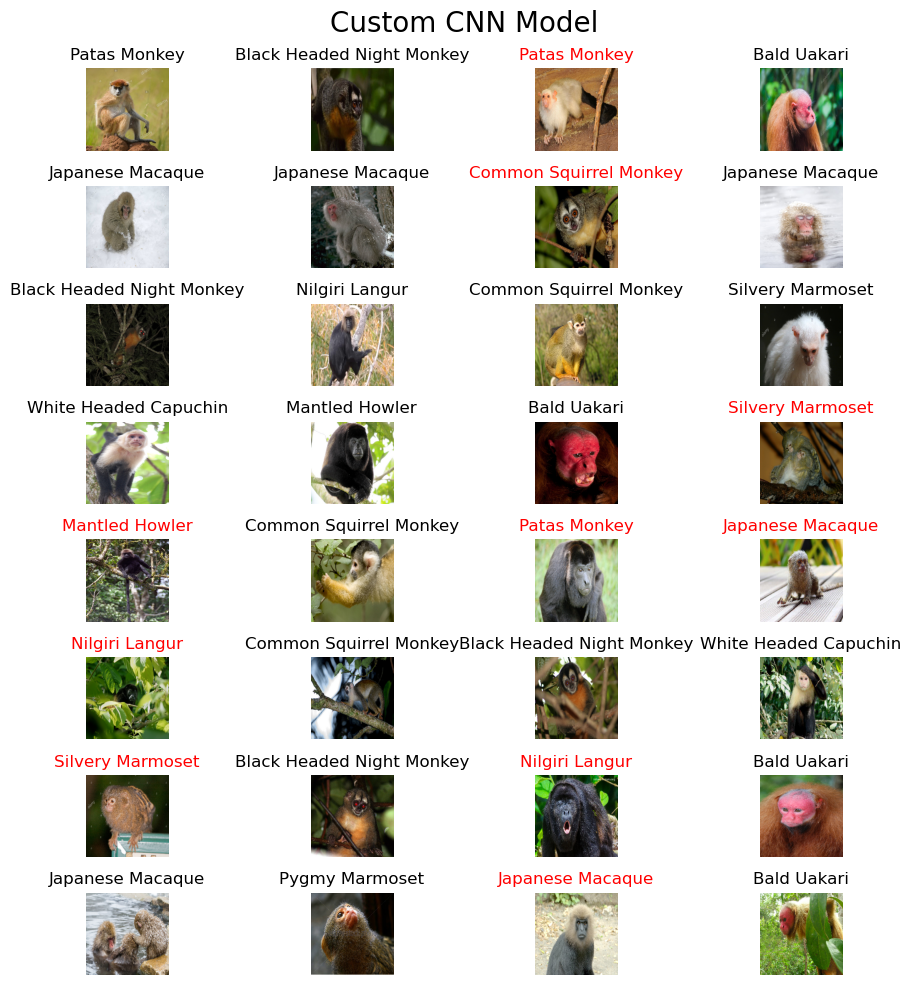

In this batch the model got 68.75% correct.


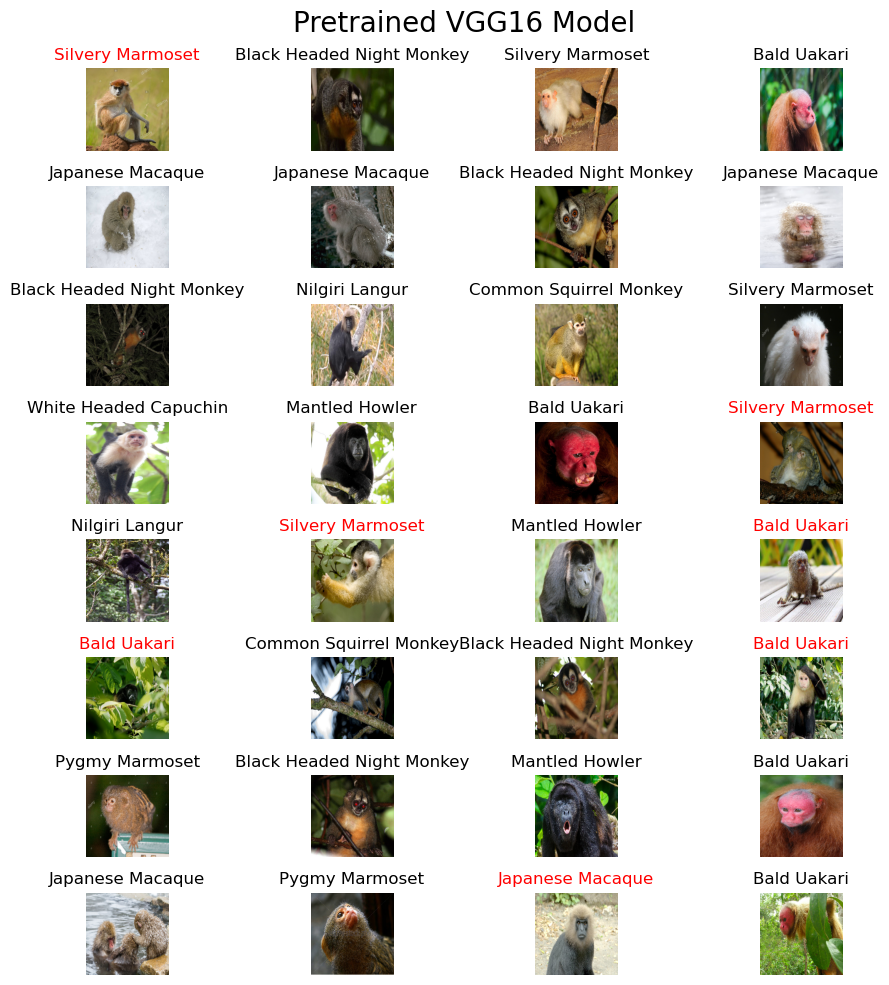

In this batch the model got 78.125% correct.


In [68]:
x_val_batch, y_val_batch = next(validation_generator)
batch_size = x_val_batch.shape[0]

def plot_predictions(model, title):
    batch_incorrect_count = 0
    fig, ax = plt.subplots(int(batch_size / 4), 4, figsize = (10,10))
    fig.suptitle(title, fontsize = 20)
    ax = ax.flatten()
    for i in range(batch_size):
        x_img = np.expand_dims(x_val_batch[i], axis=0) 
        y = np.argmax(tf.nn.softmax(model.predict(x_img, verbose = 0)))
        label_color = "black"
        if y != np.expand_dims(y_val_batch[i], axis = 0):
            label_color = "red"
            batch_incorrect_count += 1
        ax[i].imshow(x_val_batch[i])
        ax[i].set_title(species_dictionary.get(y, 0), color = label_color)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()
    percent_correct = (batch_size - batch_incorrect_count) / batch_size * 100
    print(f"In this batch the model got {percent_correct}% correct.")
# CNN Model
plot_predictions(model, "Custom CNN Model")
# Pretrained Model
plot_predictions(pretrained_model, "Pretrained VGG16 Model")